In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
from astropy.io import fits
from astropy.table import Table
import pcmdpy as ppy
import easydarkfigs
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
%matplotlib inline

In [2]:
# files = {'F475W': ['../data/M49/raw/M49_F475W_EXP{:d}_flc.fits'.format(i) for i in range(1, 3)],
#          'F814W': ['../data/M49/raw/M49_F850LP_EXP{:d}_flc.fits'.format(i) for i in range(1, 3)]}
outputs = {'F475W': '../data/m31/raw/hlsp_phat_hst_acs-wfc_12058-m31-b01_f475w_v1_drz_ALIGNED.fits',
          'F814W': '../data/m31/raw/hlsp_phat_hst_acs-wfc_12058-m31-b01_f814w_v1_drz.fits'}
diff_im = '../data/M31/raw/gI.fits'
darks = {}

Setting up logfile :  tweakreg.log
TweakReg Version 1.4.7(18-April-2018) started at: 19:04:07.933 (11/04/2019) 

Version Information
--------------------
Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 12:04:33) 
numpy Version -> 1.15.1 
astropy Version -> 3.1.2 
stwcs Version -> 1.4.2 

Finding shifts for: 
    /Users/bcook/pCMDs/pixcmd/data/m31/raw/hlsp_phat_hst_acs-wfc_12058-m31-b01_f814w_v1_drz.fits
    /Users/bcook/pCMDs/pixcmd/data/m31/raw/hlsp_phat_hst_acs-wfc_12058-m31-b01_f475w_v1_drz_ALIGNED.fits

===  Source finding for image '/Users/bcook/pCMDs/pixcmd/data/m31/raw/hlsp_phat_hst_acs-wfc_12058-m31-b01_f814w_v1_drz.fits':
  #  Source finding for '/Users/bcook/pCMDs/pixcmd/data/m31/raw/hlsp_phat_hst_acs-wfc_12058-m31-b01_f814w_v1_drz.fits', EXT=('SCI', 1) started at: 19:04:10.323 (11/04/2019)
     Found 6797 objects.
===  FINAL number of objects in image '/Users/bcook/pCMDs/pixcmd/data/m31/raw/hl

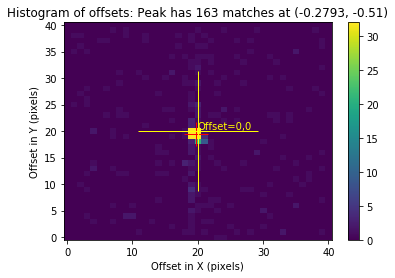

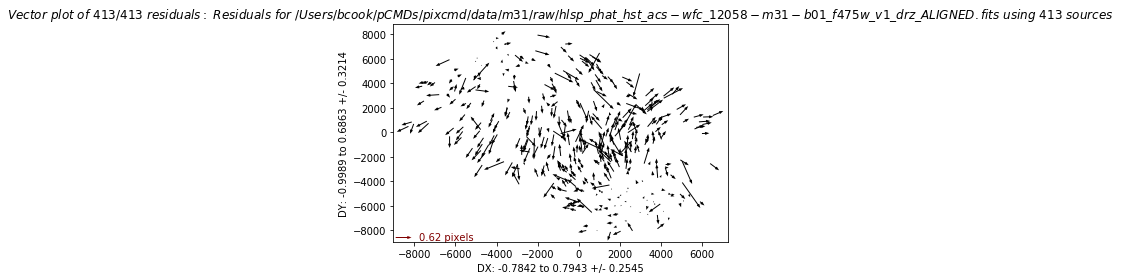

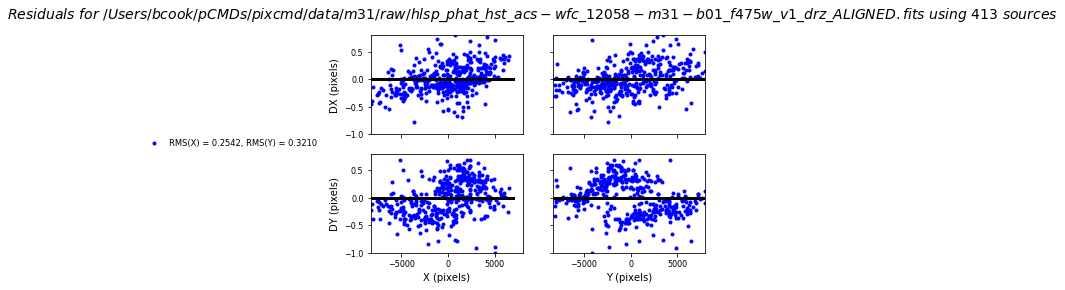

In [3]:
from drizzlepac import tweakreg
tweakreg.TweakReg([outputs['F814W'], outputs['F475W']], conv_width=4.0, threshold=200, shiftfile=False, writecat=False, clean=True,
                 interactive=False)

In [4]:
fw = ppy.instrument.m31_winter_filters()
fs = ppy.instrument.m31_summer_filters()

In [36]:
iso_model = ppy.isochrones.Isochrone_Model(fw, mag_system='ab')
driv = ppy.driver.Driver(iso_model)

GPU acceleration not available. Continuing without.

In [45]:
fw[0]._exposure * 23.429 * (0.05**2) , fw[1]._exposure * 12.039 * (0.05**2)

(200.90367500000005, 114.37050000000002)

In [46]:
fs[0]._exposure * 23.429 * (0.05**2) , fs[1]._exposure * 12.039 * (0.05**2)

(178.06040000000002, 103.53540000000001)

In [47]:
pcmds = {}
for i, k in enumerate(['summer_r1', 'winter_r9', 'winter_r1', 'winter_r2', 'winter_r10']):
    pcmds[i] = np.loadtxt(f'../data/m31/pcmds/m31_{k}.pcmd', unpack=True)

In [40]:
g = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.SingleFeH(),
    ppy.dustmodels.SingleDust(dust_frac=1.0),
    ppy.sfhmodels.TauModel(iso_step=-1),
    ppy.distancemodels.FixedDistance(dmod=24.47)
)

In [41]:
sky = [200.9, 114.4]

In [48]:
%%time
g.set_params(np.array([0., -2.0, 2.0, 2.]))
pcmd2, _ = driv.simulate(g, 256, sky_noise=sky, dither=False, mag_system='ab')
g.set_params(np.array([0., -2.0, 2.5, 2.]))
pcmd25, _ = driv.simulate(g, 256, sky_noise=sky, dither=False, mag_system='ab')
g.set_params(np.array([0., -2.0, 3.0, 2.]))
pcmd3, _ = driv.simulate(g, 256, sky_noise=sky, dither=False, mag_system='ab')
g.set_params(np.array([0., -2.0, 3.5, 2.]))
pcmd35, _ = driv.simulate(g, 256, sky_noise=sky, dither=False, mag_system='ab')
g.set_params(np.array([0., -2.0, 4.0, 2.]))
pcmd4, _ = driv.simulate(g, 256, sky_noise=sky, dither=False, mag_system='ab')

CPU times: user 25.1 s, sys: 6.52 s, total: 31.6 s
Wall time: 32.2 s


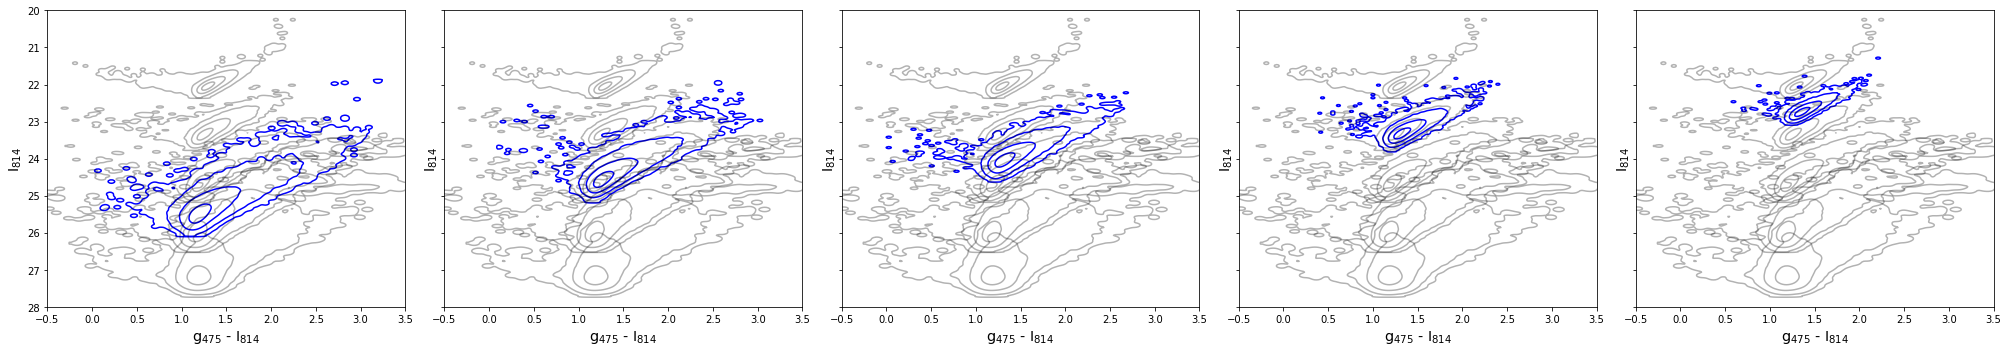

In [50]:
fig, axes = plt.subplots(ncols=5, figsize=(28, 5), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    ppy.plotting.plot_pcmd_contours(pcmds[i], ax=ax, color='b')
    for p in [pcmd2, pcmd25, pcmd3, pcmd35, pcmd4]:
        ppy.plotting.plot_pcmd_contours(p, ax=ax, color='k', alpha=0.3)
    ppy.plotting.plot_isochrone(iso_model, axes=ax, alpha=0.)
axes[0].set_ylim([28, 20])
axes[0].set_xlim([-0.5, 3.5])

fig.tight_layout()